# Processing the results of the experiment

In [191]:
import importlib
import utils
importlib.reload(utils) # Reload instead of using cached version

# Imports
import pandas as pd
import glob
from pathlib import Path
import os
import subprocess
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Make sure we're using python 3.10.1 (same as version on short)
!python3 --version

Python 3.10.1


## Setup

In [192]:
# Set root to git subfolder
git_root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
os.chdir(git_root)

In [193]:
RESULT_DIR = "experiments/temp_results"

Lets first extract all the experiments and trial (folds)

In [194]:
get_root_name = lambda path : path.split("/")[-2]

df = pd.DataFrame()

# Loop through all the search algorithms
search_algorithms = glob.glob(RESULT_DIR + "/*/")
for search_algorithm in search_algorithms:
    rl_algorithms = glob.glob(search_algorithm + "/*/")
    for rl_algorithm in rl_algorithms:
        trial_numbers = glob.glob(rl_algorithm + "/*/")
        for trial_number in trial_numbers:
            path_log = trial_number + "logs/"
            new_row = pd.DataFrame([{"search_algorithm": get_root_name(search_algorithm), "rl_algorithm": get_root_name(rl_algorithm), "trial_number": get_root_name(trial_number).split("_")[-1], "path_log": path_log}])
            df = pd.concat([df, new_row], ignore_index=True)
df

,search_algorithm,rl_algorithm,trial_number,path_log
0,BestImprovementNoTabu,baseline,1,experiments/temp_results/BestImprovementNoTabu...
1,BestImprovementNoTabu,baseline,2,experiments/temp_results/BestImprovementNoTabu...
2,BestImprovementNoTabu,epsilon_greedy,1,experiments/temp_results/BestImprovementNoTabu...
3,BestImprovementNoTabu,epsilon_greedy,2,experiments/temp_results/BestImprovementNoTabu...
4,RandomSearch,baseline,1,experiments/temp_results/RandomSearch/baseline...
5,RandomSearch,baseline,2,experiments/temp_results/RandomSearch/baseline...
6,RandomSearch,epsilon_greedy,1,experiments/temp_results/RandomSearch/epsilon_...
7,RandomSearch,epsilon_greedy,2,experiments/temp_results/RandomSearch/epsilon_...


## Preprocessing

In [195]:
# Columns in tvec.csv: 
# algo_name,algo_name_nice,scenario_name,scenario_name_nice,seed,k,patch,patch_clean,patch_valid,diff,diff_valid,stats_steps,stats_steps_useful,stats_steps_useful_105,log_time_search,log_time_validation,log_time_test,log_time_valid_test,log_time_all,log_time_valid_all,fit_search,fit_training,fit_validation,fit_test,fit_all,fit_valid_training,fit_valid_validation,fit_valid_test,fit_valid_all,fit_init_search,fit_init_training,fit_init_validation,fit_init_test,fit_init_all,fit_init_valid_training,fit_init_valid_validation,fit_init_valid_test,fit_init_valid_all,runtime_test,runtime_all,runtime_valid_test,runtime_valid_all,runtime_init_test,runtime_init_all,runtime_init_valid_test,runtime_init_valid_all,patch_size,patch_clean_size,patch_valid_size,ratio_fit_search,ratio_fit_training,ratio_fit_validation,ratio_fit_test,ratio_fit_all,ratio_fit_valid_training,ratio_fit_valid_validation,ratio_fit_valid_test,ratio_fit_valid_all,ratio_runtime_test,ratio_runtime_all,ratio_runtime_valid_test,ratio_runtime_valid_all,ratio_steps_useful,ratio_steps_useful_105
# TODO: stats_steps,stats_steps_useful,stats_steps_useful_105,log_time_search,log_time_validation,log_time_test,log_time_valid_test,log_time_all,log_time_valid_all,fit_search,fit_training,fit_validation,fit_test,fit_all,fit_valid_training,fit_valid_validation,fit_valid_test,fit_valid_all,fit_init_search,fit_init_training,fit_init_validation,fit_init_test,fit_init_all,fit_init_valid_training,fit_init_valid_validation,fit_init_valid_test,fit_init_valid_all,runtime_test,runtime_all,runtime_valid_test,runtime_valid_all,runtime_init_test,runtime_init_all,runtime_init_valid_test,runtime_init_valid_all,patch_size,patch_clean_size,patch_valid_size,ratio_fit_search,ratio_fit_training,ratio_fit_validation,ratio_fit_test,ratio_fit_all,ratio_fit_valid_training,ratio_fit_valid_validation,ratio_fit_valid_test,ratio_fit_valid_all,ratio_runtime_test,ratio_runtime_all,ratio_runtime_valid_test,ratio_runtime_valid_all,ratio_steps_useful,ratio_steps_useful_105

In [196]:
# Extract Pickle Object
df['pkl_obj'] = df['path_log'].apply(utils.generate_pickle_object)
df['pkl_obj'].iloc[0] # Example of what the pickle object looks like

{'stop': 'time budget',
 'best_patch': <magpie.base.patch.Patch at 0x7f24e8e63fd0>,
 'initial_patch': <magpie.base.patch.Patch at 0x7f24e8e9ec80>,
 'initial_fitness': 1205550,
 'best_fitness': 1202772,
 'diff': '--- before: triangle.cpp\n+++ after: triangle.cpp\n@@ -2,20 +2,20 @@\n \n void delay() {\n   const struct timespec ms = {0, (long int) (0.001*1e9)}; //tv_sec=0, tv_nsec (0.001 seconds)\n-  nanosleep(&ms,NULL); /*ignores possible errors*/\n+  delay(); /*ignores possible errors*/\n }\n \n int classify_triangle(double a, double b, double c) {\n   double tmp;\n \n-  delay();\n+  if(b > c) {\n+    tmp = b;\n+    b = c;\n+    c = tmp;\n+  }\n \n   // Sort the sides so that a <= b <= c\n-  if(a > b) {\n-    tmp = a;\n-    a = b;\n-    b = tmp;\n-  }\n+  \n \n   if(a > c) {\n     tmp = a;\n@@ -23,11 +23,7 @@\n     c = tmp;\n   }\n \n-  if(b > c) {\n-    tmp = b;\n-    b = c;\n-    c = tmp;\n-  }\n+  \n \n   if(a + b <= c)\n     /*auto*/{\n',
 'warmup_values': [1205550, 1205551, 1205551

In [197]:
# Extract some common columns we might need

# df['seed'] = df['pkl_obj'].apply(lambda x: x['seed'])
df['diff'] = df['pkl_obj'].apply(lambda x: x['diff'])
df['initial_fitness'] = df['pkl_obj'].apply(lambda x: x['initial_fitness'])
df['best_fitness'] = df['pkl_obj'].apply(lambda x: x['best_fitness'])
df['patch'] = df['path_log'].apply(utils.get_patch)

## Analysis

### Warmup Consistency

First we explore the variance of the warmup phase. For our experiment, we used to perf function in hopes of minimizing the variance of the warmup phase. The hope is that the variance of the warmup phase is small enough that we can ignore it. We will explore this assumption here.

In [198]:
df['warmup_values'] = df['pkl_obj'].apply(lambda x: np.array(x['warmup_values']))
df['warmup_values']

0    [1205550, 1205551, 1205551, 1205551, 1205550]
1    [1205551, 1205550, 1205551, 1205550, 1205550]
2    [1205550, 1205551, 1205550, 1205551, 1205550]
3    [1266932, 1205550, 1205551, 1205551, 1205550]
4    [1315754, 1205550, 1290036, 1205550, 1205550]
5    [1205549, 1205551, 1452280, 1205551, 1205550]
6    [1205551, 1220717, 1205549, 1205551, 1205550]
7    [1205552, 1205551, 1205551, 1205549, 1205550]
Name: warmup_values, dtype: object

We notice that the perf function creates values that are very close together +- 1 instruction. However, there are some significant outliers..We create a boxplot to better visualize the variance of the warmup phase.

2


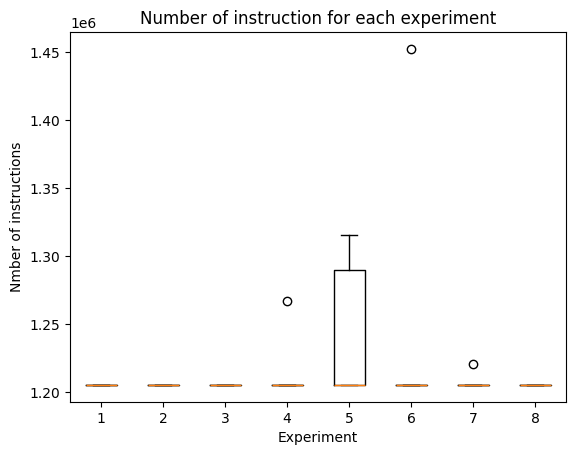

In [201]:
# Creating a boxplot for each experiment
plt.boxplot([df['warmup_values'].iloc[i] for i in range(len(df))])
plt.title('Number of instruction for each experiment')
plt.ylabel('Nmber of instructions')
plt.xlabel('Experiment')
plt.show()

Each experiment should execute the same number of instructions, so we can combine all the warmup trials.

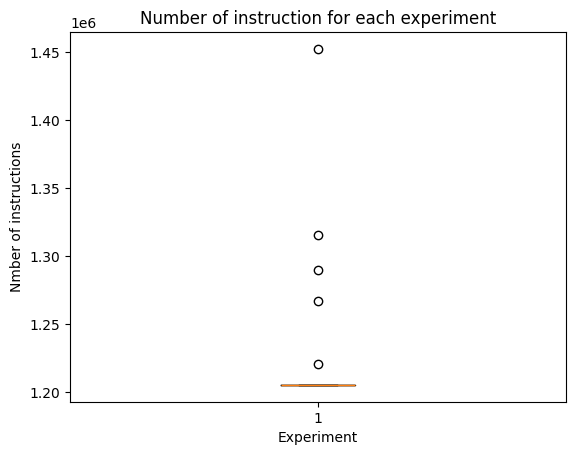

In [202]:
combined_np_array = np.concatenate([df['warmup_values'].iloc[i] for i in range(len(df))])
plt.boxplot(combined_np_array)
plt.title('Number of instruction for each experiment')
plt.ylabel('Nmber of instructions')
plt.xlabel('Experiment')
plt.show()

We notice that the variance is mostly consistance, however, at times the number of instructions exectued jump up very significantly. We will explore this further in the next section.

In [205]:
combined_np_array

array([1205550, 1205551, 1205551, 1205551, 1205550, 1205551, 1205550,
       1205551, 1205550, 1205550, 1205550, 1205551, 1205550, 1205551,
       1205550, 1266932, 1205550, 1205551, 1205551, 1205550, 1315754,
       1205550, 1290036, 1205550, 1205550, 1205549, 1205551, 1452280,
       1205551, 1205550, 1205551, 1220717, 1205549, 1205551, 1205550,
       1205552, 1205551, 1205551, 1205549, 1205550])

In [220]:
def get_outliers():
    # Get outliers
    Q1 = np.quantile(combined_np_array, 0.25)
    Q3 = np.quantile(combined_np_array, 0.75)
    IQR = Q3 - Q1
    outliers = combined_np_array[(combined_np_array < Q1 - 1.5 * IQR) | (combined_np_array > Q3 + 1.5 * IQR)]
    return outliers

outliers = get_outliers()

print(f"There are {len(outliers)} outliers, so {len(outliers) * 100 / len(combined_np_array):.2f}% of the data is outliers")

# Percentage difference from median
average_outlier_magnitude = ((outliers / np.median(combined_np_array)) - 1) * 100
print(f"Average outlier magnitude: {np.mean(average_outlier_magnitude):.2f}%")

    

There are 5 outliers, so 12.50% of the data is outliers
Average outlier magnitude: 8.59%
